In [2]:
!pip install trino


[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
!pip install matplotlib

     ---------------------------------------- 0.0/52.8 kB ? eta -:--:--
     -------------- ----------------------- 20.5/52.8 kB 640.0 kB/s eta 0:00:01
     ------------------------------------ - 51.2/52.8 kB 518.5 kB/s eta 0:00:01
     -------------------------------------- 52.8/52.8 kB 539.2 kB/s eta 0:00:00
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
     ---------------------------------------- 0.0/116.4 kB ? eta -:--:--
     -------------------- ------------------ 61.4/116.4 kB 1.7 MB/s eta 0:00:01
     -------------------------------------- 116.4/116.4 kB 1.7 MB/s eta 0:00:00
   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
    --------------------------------------- 0.2/8.1 MB 5.6 MB/s eta 0:00:02
   -- ------------------------------------- 0.5/8.1 MB 5.9 MB/s eta 0:00:02
   ---- ----------------------------------- 1.0/8.1 MB 7.9 MB/s eta 0:00:01
   ---------- ----------------------------- 2.0/8.1 MB 11.8 MB/s eta 0:00:01
   --------------


[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [5]:
import trino
import pandas as pd
import matplotlib.pyplot as plt

In [33]:
conn = trino.dbapi.connect(
    host="host.docker.internal",
    port=8080,
    user="student",
    catalog="iceberg",
    schema="demo",
)
cur = conn.cursor()

In [34]:
def q(sql):
    cur.execute(sql)
    rows = cur.fetchall()
    return pd.DataFrame(rows, columns=[c[0] for c in cur.description]) if cur.description else None

In [35]:
print("Каталоги:")
print(q("SHOW CATALOGS"))

Каталоги:
      Catalog
0  postgresql
1      system


In [36]:
print("Схемы PostgreSQL:")
print(q("SHOW SCHEMAS FROM postgresql"))

Схемы PostgreSQL:
               Schema
0  information_schema
1          pg_catalog
2              public


In [37]:
print("Таблицы PostgreSQL:")
print(q("SHOW TABLES FROM postgresql.public"))

Таблицы PostgreSQL:
        Table
0  trn_orders


In [38]:
q("CREATE TABLE IF NOT EXISTS postgresql.public.trn_orders (order_id INTEGER, customer_id INTEGER, order_ts TIMESTAMP, total_amount DOUBLE)")

In [39]:
q("CREATE TABLE IF NOT EXISTS postgresql.public.trn_customers (customer_id INTEGER, name VARCHAR, email VARCHAR)")

In [40]:
q("DELETE FROM postgresql.public.trn_orders")
q("DELETE FROM postgresql.public.trn_customers")

,rows
0,0


In [41]:
q("INSERT INTO postgresql.public.trn_customers (customer_id, name, email) VALUES (1, 'Иван', 'ivan@test.com'), (2, 'Мария', 'maria@test.com'), (3, 'Алексей', 'alex@test.com')")

,rows
0,3


In [42]:
q("""
INSERT INTO postgresql.public.trn_orders (order_id, customer_id, order_ts, total_amount)
WITH max_order AS (SELECT COALESCE(MAX(order_id), 0) AS max_id FROM postgresql.public.trn_orders),
c AS (SELECT customer_id, row_number() OVER (ORDER BY customer_id) AS rn FROM postgresql.public.trn_customers),
cnt AS (SELECT MAX(rn) AS n FROM c),
gen AS (SELECT (max_id + x) AS order_id, x FROM max_order CROSS JOIN UNNEST(sequence(1, 50)) AS t(x))
SELECT gen.order_id, c.customer_id,
current_timestamp - INTERVAL '1' DAY * CAST(rand() * 30 AS integer) - INTERVAL '1' MINUTE * CAST(rand() * 1440 AS integer) AS order_ts,
round(10 + rand() * 990, 2) AS total_amount
FROM gen CROSS JOIN cnt JOIN c ON c.rn = ((gen.x - 1) % cnt.n) + 1
""")

,rows
0,50


In [43]:
df_orders_daily = q("SELECT date_trunc('day',order_ts) as dt, count(*) as orders_cnt, sum(total_amount) as revenue FROM postgresql.public.trn_orders group by 1 order by 1")
print("Выручка по дням:")
print(df_orders_daily)

Выручка по дням:
           dt  orders_cnt  revenue
0  2025-12-06           1   197.05
1  2025-12-07           2  1877.17
2  2025-12-08           1   962.83
3  2025-12-09           1   122.68
4  2025-12-10           1   631.37
5  2025-12-11           1   608.84
6  2025-12-12           1   535.50
7  2025-12-13           1   450.91
8  2025-12-14           1   788.09
9  2025-12-15           1   400.28
10 2025-12-16           1   285.28
11 2025-12-17           2   816.79
12 2025-12-18           2   577.75
13 2025-12-19           1   534.38
14 2025-12-20           2  1024.29
15 2025-12-22           2   924.23
16 2025-12-23           3  1120.94
17 2025-12-24           3   822.10
18 2025-12-25           1   416.61
19 2025-12-26           1   272.86
20 2025-12-29           3  1399.38
21 2025-12-30           1   904.71
22 2025-12-31           2   677.22
23 2026-01-01           5  2190.08
24 2026-01-02           4  1938.71
25 2026-01-03           1   986.43
26 2026-01-04           2   640.23
27 

In [44]:
df_customers_stats = q("SELECT customer_id, count(*) as total_orders, sum(total_amount) as total_spent FROM postgresql.public.trn_orders GROUP BY customer_id ORDER BY total_spent DESC")
print("Статистика по клиентам:")
print(df_customers_stats)

Статистика по клиентам:
   customer_id  total_orders  total_spent
0            1            17      8221.31
1            3            16      8162.86
2            2            17      7651.08


(array([20427., 20431., 20435., 20439., 20443., 20447., 20451., 20454.,
        20458.]),
 [Text(20427.0, 0, '2025-12-05'),
  Text(20431.0, 0, '2025-12-09'),
  Text(20435.0, 0, '2025-12-13'),
  Text(20439.0, 0, '2025-12-17'),
  Text(20443.0, 0, '2025-12-21'),
  Text(20447.0, 0, '2025-12-25'),
  Text(20451.0, 0, '2025-12-29'),
  Text(20454.0, 0, '2026-01-01'),
  Text(20458.0, 0, '2026-01-05')])

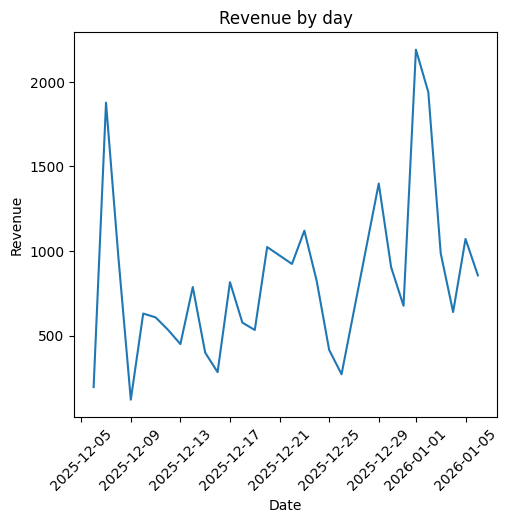

In [45]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(df_orders_daily["dt"], df_orders_daily["revenue"])
plt.title("Revenue by day")
plt.xlabel("Date")
plt.ylabel("Revenue")
plt.xticks(rotation=45)

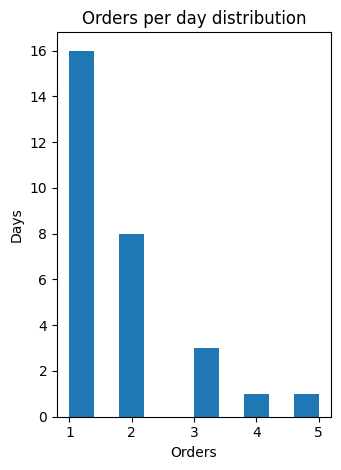

In [46]:
plt.subplot(1, 2, 2)
plt.hist(df_orders_daily["orders_cnt"], bins=10)
plt.title("Orders per day distribution")
plt.xlabel("Orders")
plt.ylabel("Days")
plt.tight_layout()
plt.show()

In [49]:
q("CREATE TABLE IF NOT EXISTS postgresql.public.daily_aggregates (dt TIMESTAMP, orders_cnt BIGINT, revenue DOUBLE)")

In [50]:
for _, row in df_orders_daily.iterrows():
    q(f"INSERT INTO postgresql.public.daily_aggregates VALUES (TIMESTAMP '{row['dt'].strftime('%Y-%m-%d %H:%M:%S')}', {row['orders_cnt']}, {row['revenue']})")

In [51]:
print(q("SELECT * FROM postgresql.public.daily_aggregates ORDER BY dt"))

           dt  orders_cnt  revenue
0  2025-12-06           1   197.05
1  2025-12-07           2  1877.17
2  2025-12-08           1   962.83
3  2025-12-09           1   122.68
4  2025-12-10           1   631.37
5  2025-12-11           1   608.84
6  2025-12-12           1   535.50
7  2025-12-13           1   450.91
8  2025-12-14           1   788.09
9  2025-12-15           1   400.28
10 2025-12-16           1   285.28
11 2025-12-17           2   816.79
12 2025-12-18           2   577.75
13 2025-12-19           1   534.38
14 2025-12-20           2  1024.29
15 2025-12-22           2   924.23
16 2025-12-23           3  1120.94
17 2025-12-24           3   822.10
18 2025-12-25           1   416.61
19 2025-12-26           1   272.86
20 2025-12-29           3  1399.38
21 2025-12-30           1   904.71
22 2025-12-31           2   677.22
23 2026-01-01           5  2190.08
24 2026-01-02           4  1938.71
25 2026-01-03           1   986.43
26 2026-01-04           2   640.23
27 2026-01-05       

In [52]:
cur.close()
conn.close()